## 添加引用

In [1]:
import utils
import params
import cv2
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## 从Tesla数据集的视频中，得到训练图片，并对图片做裁剪和缩放。从数据集的车辆转向记录中读取转向数据，将转向数据和训练图片做一一对应，得到训练数据集。

In [2]:
def img_pre_process(img, resize_w, resize_h):
    """
    将图片减去靠近底部150像素高度，显示车身的部分，和顶部有大约1/3的天空部分
    """    
    shape = img.shape
    img = img[int(shape[0]/3):shape[0]-150, 0:shape[1]]
    img = cv2.resize(img, (resize_w, resize_h), interpolation=cv2.INTER_CUBIC)

    return np.resize(img, (resize_h, resize_w, params.FLAGS.img_c))


In [3]:
def loadVideoAndResize(resize_w, resize_h):
    """
    #加载epoch1到epoch10的所有视频的图片到img_list中，加载epoch1到epoch10的所有转向数据到steer_list，
    """
    for epoch_id in range(1,11):    
        vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mkv').format(epoch_id)
        steer_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_steering.csv').format(epoch_id)
        steer_data = utils.fetch_csv_data(steer_path)
    
        steer_list = steer_data['wheel'] 
    
        frame_count = utils.frame_count(vid_path)
        cap = cv2.VideoCapture(vid_path)
        img_list = []
    
        for frame_id in range(frame_count):
            ret, img = cap.read()       
            img_resized = img_pre_process(img, resize_w, resize_h)
            img_list.append(img_resized)
        
            if frame_id == frame_count - 1 and epoch_id == 1:
                #可视化一张图片
                print("img pre shape {}".format(img.shape))
                print("img after shape {}".format(img_resized.shape))
                plt.imshow(img)
                plt.show()
                plt.imshow(img_resized)
                plt.show()
    
   
    #把数据集存到本地
        train_add = 'epoch{:0>2}_{}_{}_preprocess_train.p'.format(epoch_id, resize_w,resize_h)
        pickle.dump((img_list, steer_list), open(train_add, 'wb'))



In [5]:
#定义加载存好的图像数据的方法
def load_preprocess_training_batch(batch_id, resize_w, resize_h):
    filename = 'epoch{:0>2}_{}_{}_preprocess_train.p'.format(batch_id, resize_w, resize_h)
    img, steer = pickle.load(open(filename, mode='rb'))

    return img, steer
def load_preprocess_validating_batch(batch_id, resize_w, resize_h):
    filename = 'epoch{:0>2}_{}_{}_preprocess_val.p'.format(batch_id, resize_w, resize_h)
    img, steer = pickle.load(open(filename, mode='rb'))

    return img, steer

### 将所有的视频解码成图片，存在本地

/home/ubuntu/tesla/for_tesla/epochs/epoch01_front.mkv
img pre shape (720, 1280, 3)
img after shape (66, 200, 3)


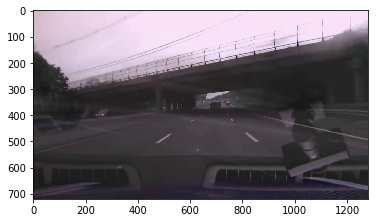

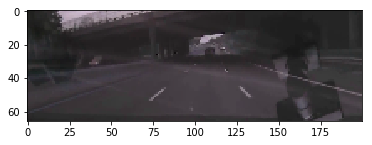

/home/ubuntu/tesla/for_tesla/epochs/epoch02_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch03_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch04_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch05_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch06_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch07_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch08_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch09_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch10_front.mkv


In [4]:
#将视频解码成预训练网络需要的图片尺寸的图片 
loadVideoAndResize(200, 66)

## 算法部分

In [7]:
#将输出的转向角度处理成间隔为0.5的数值，这是因为训练数据和测试数据的转向角度都是这样的数据
def nor_output(pre_y):
    pre = pre_y.reshape(1, -1)[0]
    for i, x in enumerate(pre):
        pre[i] = round(x, 4)

    for i,x in enumerate(pre):
        if x > 0:
            if (x-math.floor(x))>=0.75:
                pre[i] = int(x) + 1.0
            elif (x-math.floor(x))>=0.25:
                pre[i] = (int(x) + 0.5)
            else:
                pre[i] = int(x)
        else:
            if (x-int(x))<=-0.75:
                pre[i] = int(x) - 1.0
            elif (x-int(x))<=-0.25:
                pre[i] = (int(x) - 0.5)
            else:
                pre[i] = int(x)
    return pre

In [74]:
#定义模型
from keras.layers import Input, Dense, Flatten, Convolution2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
def tesla_model(time_len=1):
    ch, height, width = 3, 66, 200  # camera format
    inp = Input(shape=(width,height,  ch)) 
    lam = Lambda(lambda x: x/127.5 - 1.,
            input_shape=( width, height, ch),
            output_shape=(width,height,  ch))(inp)
    conv_0 = Convolution2D(3, (5, 5),subsample=(2, 2),  padding='same', activation='relu', kernel_initializer='he_normal')(lam)
    conv_0 = BatchNormalization()(conv_0)
    conv_1 = Convolution2D(24, (5, 5),subsample=(2, 2),  padding='same', activation='relu', kernel_initializer='he_normal')(conv_0)
    conv_1 = BatchNormalization()(conv_1)
        
    conv_2 = Convolution2D(36, (5, 5),subsample=(2, 2),  padding='same', activation='relu', kernel_initializer='he_normal')(conv_1)
    conv_2 = BatchNormalization()(conv_2)#
    
    max_c2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',)(conv_2)

    conv_3 = Convolution2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(max_c2)
    conv_3 = BatchNormalization()(conv_3)
    conv_4 = Convolution2D(72, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    
    max_c4 = MaxPooling2D(pool_size=(1, 1), strides=None, padding='valid',)(conv_4)
    
    conv_5 = Convolution2D(84, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(max_c4)
    conv_5 = BatchNormalization()(conv_5)
    
    conv_6 = Convolution2D(96, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    
 #   conv_7 = Convolution2D(124, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_6)
 #   conv_7 = BatchNormalization()(conv_7)
    
 #   conv_8 = Convolution2D(212, (1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(conv_7)
 #   conv_8 = BatchNormalization()(conv_8)
    
    flat = Flatten()(conv_6)
    
    hidden2 = Dense(100, activation='relu', kernel_initializer='glorot_normal',
                   kernel_regularizer=regularizers.l2(0.00005),
                        bias_regularizer=regularizers.l2(0.00005),
                   )(flat)
    drop2 = Dropout(.5)(hidden2)
    
    hidden3 = Dense(50, activation='relu', kernel_initializer='glorot_normal',
                   kernel_regularizer=regularizers.l2(0.00005),
                        bias_regularizer=regularizers.l2(0.00005),
                   )(drop2)
       
    hidden4 = Dense(10, activation='relu',
                        kernel_regularizer=regularizers.l2(0.00005),
                        bias_regularizer=regularizers.l2(0.00003),
                      #  activity_regularizer=regularizers.l1(0.003),
                        kernel_initializer='glorot_normal')(hidden3)
    out = Dense(1, activation='linear', kernel_initializer='glorot_normal')(hidden4) 
    

    model = Model(inputs=inp, outputs=out) 
    sgd = optimizers.SGD(lr=0.00005, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)

      

    return model

In [10]:
#部分定义参数
batch_size = 64
epoches = 15
seed = 10
model_trans = (0, 2, 1, 3)

In [12]:
#训练模型的方法
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math
from decimal import Decimal
def train_model(video_list, model_func, resize_w, resize_h, ifSave = False, test_img=None, test_y=None):
    model = model_func()
    
    val_acc = []
    test_acc = []
    train_acc = []
    
    datagen_train = ImageDataGenerator(
                             
                    )
    datagen_test = ImageDataGenerator(
                              
                    )
    datagen_val = ImageDataGenerator(
                                
                    )
    #加载第10个视频的测试图片数据
    test_img, test_y = load_preprocess_training_batch(10, res_w, res_h)   
    test_img = np.array(test_img).transpose(model_trans)
    datagen_test.fit(test_img)
    for x_batch, y_batch in datagen_test.flow(test_img, test_y, batch_size=len(test_y)):
        test_img = x_batch
        test_y = y_batch
        break
    
    #加载第7个视频的图片作为验证集
    x_val, y_val = load_preprocess_training_batch(7, res_w, res_h)   
    x_val = np.array(x_val).transpose(model_trans)
    datagen_val.fit(x_val)
    for x_batch, y_batch in datagen_val.flow(x_val, y_val, batch_size=len(y_val)):
        
        x_val = x_batch
        y_val = y_batch
        break
    
    #总共训练epoches轮
    for epoch_idx in range(0, epoches):
        x_train_all = np.array([])
        y_train_all = []
        #每轮训练视频1,2,3,4,5,6,8,9的图片
        for video_idx in [1,2,3,4,5,6,8,9]:
            x_train, y_train = load_preprocess_training_batch(video_idx, resize_w, resize_h)
            x_train = np.array(x_train).transpose(model_trans)            
           
            datagen_train.fit(x_train)
            model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int (len(y_train) /batch_size) +1 , epochs=1,shuffle=True)
            
            if video_idx == 1:
                if x_train_all.shape == np.array([]).shape:
                    x_train_all = x_train
                    y_train_all = list(y_train)
                else:
                    x_train_all = np.vstack((x_train_all, x_train))
                    y_train_all.extend(list(y_train))
        
        #保存每一轮训练的训练集得分和验证集得分
        train_acc.append(test_model(model, x_train_all, y_train_all, ifShow = False, note = "train"))
        val_acc.append(test_model(model, x_val, y_val, ifShow = False, note = "val"))
    
    
    plt.plot(train_acc, color='#FF00FF', label = 'train_accuracy')
    plt.plot(val_acc,color='b', label='val_accuracy')

    plt.legend()
    plt.show()
    if ifSave == True:
        utils.save_model(model)
    return model, test_img, test_y

In [13]:
#定义测试模型方法
def test_model(model, img_list_val, y_val, ifShow=False, note=''):
    pre = model.predict(img_list_val)
    pre = nor_output(pre)

    score = r2_score(y_val, pre)
    print("%s score: %.2f " % (note,score))
    

    if type(y_val) != np.array:
        y_val = np.array(y_val)
    y_val = y_val.reshape(len(list(y_val)), 1)    
    y_val = y_val.reshape(1, -1)[0]
    x = np.arange(1, len(y_val) + 1)
    y = y_val  - pre ;

    if ifShow==True:
        plt.plot(x, abs(y) , marker = '.', color = 'b', label = 'steer bias',linewidth=0.1)
        plt.legend()
        plt.show()
    return score

### 训练前修改参数

In [14]:
res_w = 200
res_h = 66
batch_size = 64
epoches = 15
seed = 10
model_trans = (0, 2, 1, 3)

### 训练全部视频，以下为部分调试过程中的结果

#### 按照NVIDIA搭建模型最初的训练结果

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':


Epoch 1/1
24/24 [==============================] - 3s 120ms/step - loss: 10.9768
Epoch 1/1
61/61 [==============================] - 3s 46ms/step - loss: 3.6957
Epoch 1/1
43/43 [==============================] - 2s 45ms/step - loss: 7.1710
Epoch 1/1
43/43 [==============================] - 2s 45ms/step - loss: 51.7199
Epoch 1/1
43/43 [==============================] - 2s 46ms/step - loss: 14.2792
Epoch 1/1
43/43 [==============================] - 2s 45ms/step - loss: 32.5985
Epoch 1/1
43/43 [==============================] - 2s 46ms/step - loss: 24.0300
Epoch 1/1
43/43 [==============================] - 2s 45ms/step - loss: 2.7936
train score: -0.07 
val score: -0.03 
Epoch 1/1
24/24 [==============================] - 1s 45ms/step - loss: 11.2737
Epoch 1/1
61/61 [==============================] - 3s 46ms/step - loss: 3.8803
Epoch 1/1
43/43 [==============================] - 2s 45ms/step - loss: 7.6922
Epoch 1/1
43/43 [==============================] - 2s 45ms/step - loss: 70.8805
Epoch 

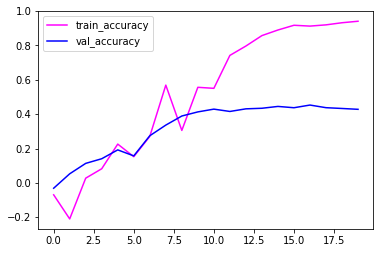

Model saved
test score: 0.04 


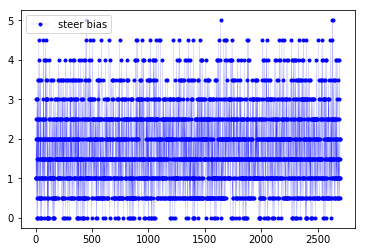

0.041677707010536524

In [49]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

#### 卷积层添加BN

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':


Epoch 1/1
24/24 [==============================] - 3s 138ms/step - loss: 9.5858
Epoch 1/1
61/61 [==============================] - 3s 54ms/step - loss: 1.1757
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 4.0978
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 16.9110
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 7.3983
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 15.1969
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 7.0352
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 1.5316
train score: -0.34 
val score: 0.28 
Epoch 1/1
24/24 [==============================] - 1s 53ms/step - loss: 5.0806
Epoch 1/1
61/61 [==============================] - 3s 55ms/step - loss: 0.9236
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 2.7914
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 5.9145
Epoch 1/1
43

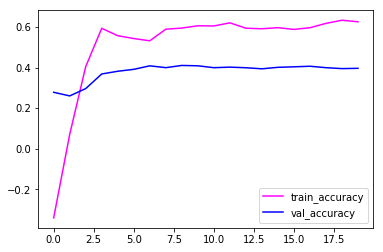

Model saved
test score: 0.36 


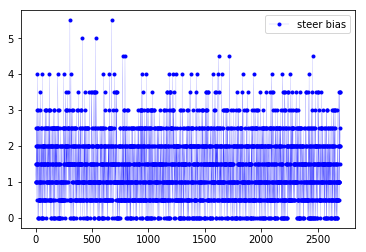

0.36399441276819855

In [51]:

model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

#### 增加模型深度，增加conv_5

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':


Epoch 1/1
24/24 [==============================] - 4s 168ms/step - loss: 8.8213
Epoch 1/1
61/61 [==============================] - 4s 69ms/step - loss: 1.6476
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 5.8338
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 26.5199
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 5.4593
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 10.2694
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 5.2921
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 1.3527
train score: -0.20 
val score: 0.22 
Epoch 1/1
24/24 [==============================] - 2s 67ms/step - loss: 3.4308: 0s - loss: 3.67
Epoch 1/1
61/61 [==============================] - 4s 68ms/step - loss: 0.8227
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 2.8324
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 5.

24/24 [==============================] - 2s 67ms/step - loss: 0.0658
Epoch 1/1
61/61 [==============================] - 4s 68ms/step - loss: 0.0513
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.1079
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 0.1210
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 0.1876
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.0976
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 0.1168
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.0383
train score: 0.56 
val score: 0.37 
Epoch 1/1
24/24 [==============================] - 2s 67ms/step - loss: 0.0550
Epoch 1/1
61/61 [==============================] - 4s 69ms/step - loss: 0.0441
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 0.0953
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 0.1195
Epoch 1/1
43/43 [=========

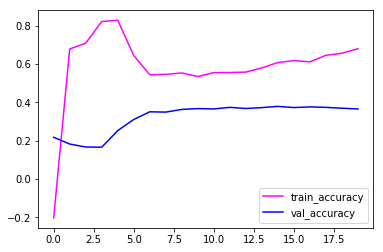

Model saved
test score: 0.43 


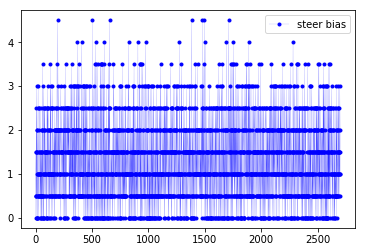

0.42663814168931979

In [55]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

#### 增加模型深度，增加conv_5和conv_6

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(84, (5, 5), padding="same", activation="relu", kernel_initial

Epoch 1/1
24/24 [==============================] - 4s 164ms/step - loss: 11.1813
Epoch 1/1
61/61 [==============================] - 3s 57ms/step - loss: 3.8353
Epoch 1/1
43/43 [==============================] - 2s 56ms/step - loss: 7.2348
Epoch 1/1
43/43 [==============================] - 2s 56ms/step - loss: 51.0157
Epoch 1/1
43/43 [==============================] - 2s 55ms/step - loss: 7.3105
Epoch 1/1
43/43 [==============================] - 2s 56ms/step - loss: 17.3914
Epoch 1/1
43/43 [==============================] - 2s 56ms/step - loss: 6.3781
Epoch 1/1
43/43 [==============================] - 2s 56ms/step - loss: 1.5550
train score: -0.21 
val score: 0.24 
Epoch 1/1
24/24 [==============================] - 1s 55ms/step - loss: 4.1851
Epoch 1/1
61/61 [==============================] - 3s 56ms/step - loss: 1.1994
Epoch 1/1
43/43 [==============================] - 2s 56ms/step - loss: 3.7742
Epoch 1/1
43/43 [==============================] - 2s 55ms/step - loss: 10.2104
Epoch 1/1


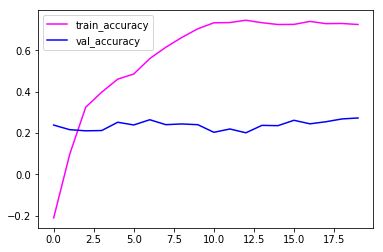

Model saved
test score: 0.30 


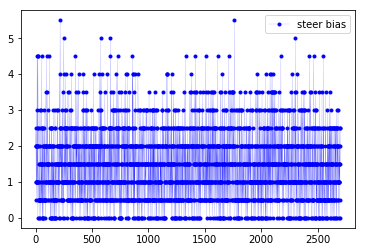

0.30194359120305403

In [57]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

#### 增加conv_6_1 1X1 con5_1 1X1

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(84, (5, 5), padding="same", activation="relu", kernel_initial

Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 11.1794
Epoch 1/1
61/61 [==============================] - 4s 64ms/step - loss: 3.8830
Epoch 1/1
43/43 [==============================] - 3s 62ms/step - loss: 7.4311
Epoch 1/1
43/43 [==============================] - 3s 62ms/step - loss: 48.6152
Epoch 1/1
43/43 [==============================] - 3s 62ms/step - loss: 6.1953
Epoch 1/1
43/43 [==============================] - 3s 62ms/step - loss: 19.4650
Epoch 1/1
43/43 [==============================] - 3s 62ms/step - loss: 8.7334
Epoch 1/1
43/43 [==============================] - 3s 62ms/step - loss: 1.2156
train score: -0.01 
val score: 0.22 
Epoch 1/1
24/24 [==============================] - 1s 62ms/step - loss: 4.5785
Epoch 1/1
61/61 [==============================] - 4s 63ms/step - loss: 1.3316
Epoch 1/1
43/43 [==============================] - 3s 62ms/step - loss: 3.2924
Epoch 1/1
43/43 [==============================] - 3s 63ms/step - loss: 9.1645
Epoch 1/1
4

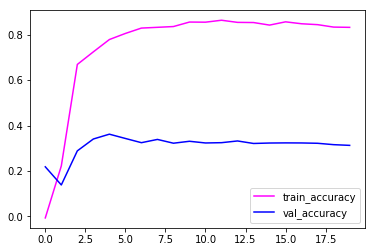

Model saved
test score: 0.51 


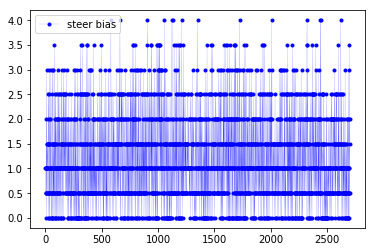

0.50533125938429224

In [69]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

#### 给全连接层hidden2,增加r2w=0.00003, r2b=0.00003

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(84, (5, 5), padding="same", activation="relu", kernel_initial

Epoch 1/1
24/24 [==============================] - 7s 290ms/step - loss: 10.7925
Epoch 1/1
61/61 [==============================] - 4s 68ms/step - loss: 3.7822
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 6.9606
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 48.3327
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 9.6053
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 18.5408
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 9.6215
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 1.7234: 0s - loss: 
train score: -0.14 
val score: 0.05 
Epoch 1/1
24/24 [==============================] - 2s 67ms/step - loss: 6.1678
Epoch 1/1
61/61 [==============================] - 4s 68ms/step - loss: 1.8844
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 3.6390
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 12.49

43/43 [==============================] - 3s 67ms/step - loss: 0.3333
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.7118
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.4361
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.4749
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.4366
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.1969
train score: 0.51 
val score: 0.35 
Epoch 1/1
24/24 [==============================] - 2s 67ms/step - loss: 0.2429
Epoch 1/1
61/61 [==============================] - 4s 68ms/step - loss: 0.1799
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.3437
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.6995
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.4317
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.4387
Epoch 1/1
43/43 [=========

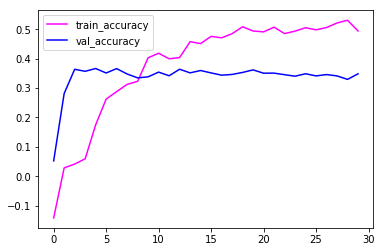

Model saved
test score: 0.49 


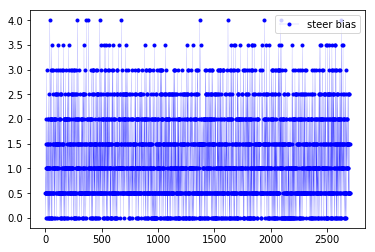

0.48631733383055775

In [83]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

#### 修改1*1卷积深度

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  del sys.path[0]


Epoch 1/1
24/24 [==============================] - 8s 326ms/step - loss: 9.6260
Epoch 1/1
61/61 [==============================] - 3s 42ms/step - loss: 2.2972
Epoch 1/1
43/43 [==============================] - 2s 42ms/step - loss: 5.8322
Epoch 1/1
43/43 [==============================] - 2s 42ms/step - loss: 28.4866
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 7.1811
Epoch 1/1
43/43 [==============================] - 2s 42ms/step - loss: 18.7171
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 6.6070
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 1.3114
train score: -0.03 
val score: 0.25 
Epoch 1/1
24/24 [==============================] - 1s 47ms/step - loss: 3.5378
Epoch 1/1
61/61 [==============================] - 3s 42ms/step - loss: 0.9084
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 3.7446
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 7.9389
Epoch 1/1
43

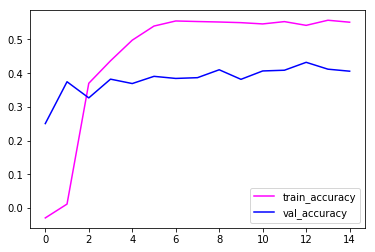

Model saved
test score: 0.45 


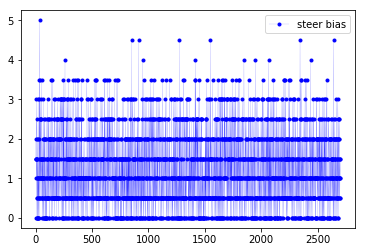

0.45434122677029876

In [75]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

#### 修改conv_3深度

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  del sys.path[0]


Epoch 1/1
24/24 [==============================] - 7s 301ms/step - loss: 9.7597
Epoch 1/1
61/61 [==============================] - 3s 42ms/step - loss: 2.6050
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 6.1923
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 30.0624
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 6.7261
Epoch 1/1
43/43 [==============================] - 2s 40ms/step - loss: 15.2328
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 7.4338
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 1.3141
train score: -0.01 
val score: 0.15 
Epoch 1/1
24/24 [==============================] - 1s 46ms/step - loss: 4.2186
Epoch 1/1
61/61 [==============================] - 3s 41ms/step - loss: 0.9772
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 3.6812
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 8.0509
Epoch 1/1
43

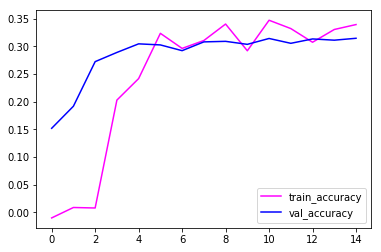

Model saved
test score: 0.39 


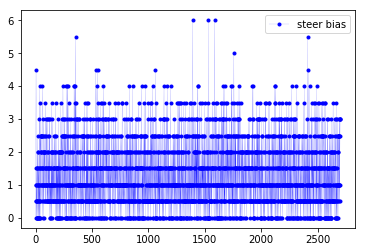

0.38811960863207695

In [68]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

#### 修改conv_2深度

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  del sys.path[0]


Epoch 1/1
24/24 [==============================] - 7s 279ms/step - loss: 7.4634
Epoch 1/1
61/61 [==============================] - 3s 41ms/step - loss: 1.8988
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 6.0070
Epoch 1/1
43/43 [==============================] - 2s 40ms/step - loss: 32.8394
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 5.4432
Epoch 1/1
43/43 [==============================] - 2s 40ms/step - loss: 10.8927
Epoch 1/1
43/43 [==============================] - 2s 40ms/step - loss: 7.1447
Epoch 1/1
43/43 [==============================] - 2s 40ms/step - loss: 0.9513
train score: 0.02 
val score: 0.30 
Epoch 1/1
24/24 [==============================] - 1s 40ms/step - loss: 3.1900
Epoch 1/1
61/61 [==============================] - 2s 41ms/step - loss: 1.1529
Epoch 1/1
43/43 [==============================] - 2s 40ms/step - loss: 4.2411
Epoch 1/1
43/43 [==============================] - 2s 40ms/step - loss: 8.9375
Epoch 1/1
43/

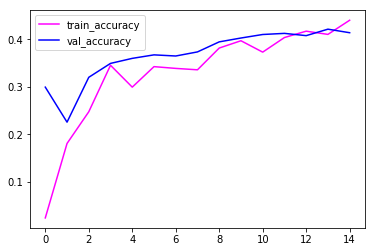

Model saved
test score: 0.44 


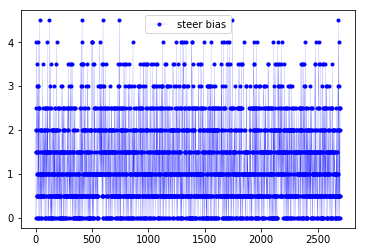

0.44107236904516567

In [64]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

#### 去掉hidden10，修改rw,rb，去掉hidden1,增加maxpooling

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':


Epoch 1/1
24/24 [==============================] - 6s 241ms/step - loss: 9.8606
Epoch 1/1
61/61 [==============================] - 2s 40ms/step - loss: 2.7933
Epoch 1/1
43/43 [==============================] - 2s 40ms/step - loss: 6.1630
Epoch 1/1
43/43 [==============================] - 2s 40ms/step - loss: 28.7571
Epoch 1/1
43/43 [==============================] - 2s 40ms/step - loss: 8.4422
Epoch 1/1
43/43 [==============================] - 2s 40ms/step - loss: 16.5146
Epoch 1/1
43/43 [==============================] - 2s 40ms/step - loss: 8.1200
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 1.4450
train score: -0.40 
val score: 0.22 
Epoch 1/1
24/24 [==============================] - 1s 41ms/step - loss: 4.8826
Epoch 1/1
61/61 [==============================] - 2s 41ms/step - loss: 1.4724
Epoch 1/1
43/43 [==============================] - 2s 41ms/step - loss: 4.2874
Epoch 1/1
43/43 [==============================] - 2s 39ms/step - loss: 9.0330
Epoch 1/1
43

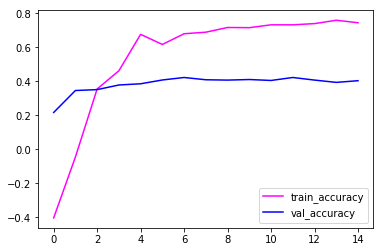

Model saved
test score: 0.41 


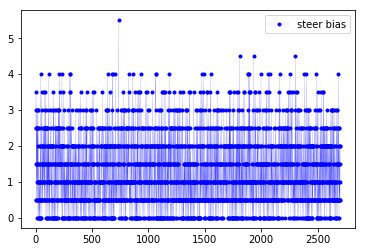

0.41065008815919035

In [56]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

#### 另外的全连接层也加上正则化

/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), activation="relu", padding="same", kernel_initializer="he_normal", strides=(2, 2))`
  
/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", padding="same", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", padding="same", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':


Epoch 1/1
24/24 [==============================] - 102s 4s/step - loss: 10.0495
Epoch 1/1
61/61 [==============================] - 221s 4s/step - loss: 2.1287
Epoch 1/1
43/43 [==============================] - 1048s 24s/step - loss: 5.2973
Epoch 1/1
43/43 [==============================] - 145s 3s/step - loss: 18.8906
Epoch 1/1
43/43 [==============================] - 155s 4s/step - loss: 7.2798
Epoch 1/1
43/43 [==============================] - 147s 3s/step - loss: 14.0121
Epoch 1/1
43/43 [==============================] - 148s 3s/step - loss: 6.5850
Epoch 1/1
43/43 [==============================] - 145s 3s/step - loss: 1.3555
train score: 0.07 
val score: 0.01 
Epoch 1/1
24/24 [==============================] - 84s 3s/step - loss: 4.5445
Epoch 1/1
61/61 [==============================] - 230s 4s/step - loss: 0.9895
Epoch 1/1
43/43 [==============================] - 148s 3s/step - loss: 3.1378
Epoch 1/1
43/43 [==============================] - 146s 3s/step - loss: 8.0107
Epoch 1/1
43

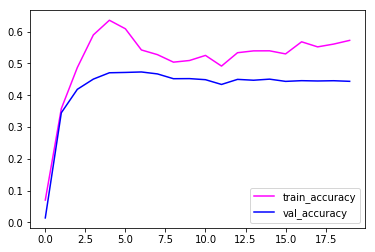

Model saved
test score: 0.49 


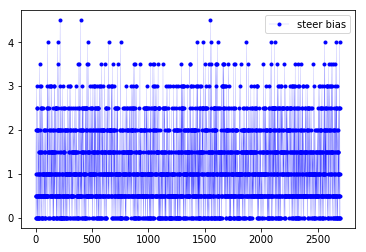

0.49179661560303178

In [18]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

#### 增加conv_9, conv9_1

In [ ]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':


Epoch 1/1


#### 去掉conv6_1

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':


Epoch 1/1
24/24 [==============================] - 8s 338ms/step - loss: 11.2710
Epoch 1/1
61/61 [==============================] - 8s 132ms/step - loss: 4.0535
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 6.1995
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 29.7983
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 6.2869
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 8.7873
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 4.9813
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 1.2390
train score: -0.09 
val score: 0.17 
Epoch 1/1
24/24 [==============================] - 3s 130ms/step - loss: 3.9898
Epoch 1/1
61/61 [==============================] - 8s 131ms/step - loss: 1.1277
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 2.8603
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 8.4007
E

Epoch 1/1
61/61 [==============================] - 8s 132ms/step - loss: 0.0410
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.0935
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.1260
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.1092
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.1486
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.1195
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.0299
train score: 0.87 
val score: 0.34 
Epoch 1/1
24/24 [==============================] - 3s 129ms/step - loss: 0.0479
Epoch 1/1
61/61 [==============================] - 8s 131ms/step - loss: 0.0369
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.0938
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.1312
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.0993
Epoc

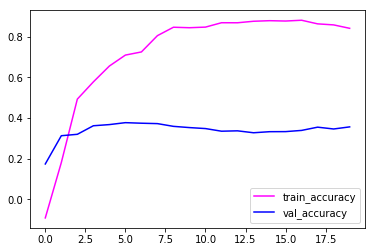

Model saved
test score: 0.39 


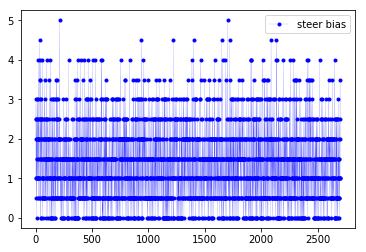

0.39182016833662092

In [56]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

#### 去掉正则化

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(84, (5, 5), padding="same", activation="relu", kernel_initial

Epoch 1/1
24/24 [==============================] - 6s 269ms/step - loss: 12.6666
Epoch 1/1
61/61 [==============================] - 6s 98ms/step - loss: 4.2726
Epoch 1/1
43/43 [==============================] - 4s 97ms/step - loss: 7.5703
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 64.3735
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 7.8670
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 21.1631
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 10.3202
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 2.0588
train score: -0.17 
val score: 0.03 
Epoch 1/1
24/24 [==============================] - 2s 97ms/step - loss: 5.8260
Epoch 1/1
61/61 [==============================] - 6s 99ms/step - loss: 1.8023
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 4.1150
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 13.9893
Epoch 1/1

Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.3723
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.7874
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.5094
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.5553
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.4496
Epoch 1/1
43/43 [==============================] - 4s 97ms/step - loss: 0.2122
train score: 0.49 
val score: 0.33 
Epoch 1/1
24/24 [==============================] - 2s 97ms/step - loss: 0.2874
Epoch 1/1
61/61 [==============================] - 6s 99ms/step - loss: 0.2068
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.3739
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.7479
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.4744
Epoch 1/1
43/43 [==============================] - 4s 99ms/step - loss: 0.4859
Epoch 1/1
43/43 

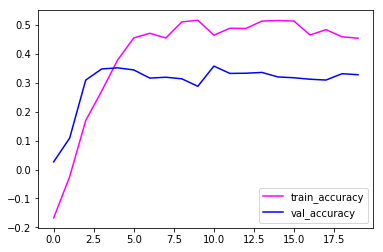

Model saved
test score: 0.50 


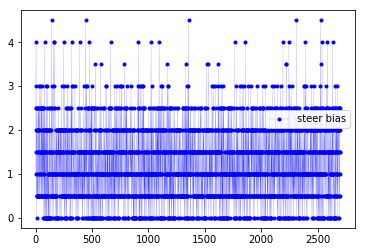

0.50075156118640352

In [44]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

#### 修改conv7_1 为3*3

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(84, (5, 5), padding="same", activation="relu", kernel_initial

Epoch 1/1
24/24 [==============================] - 9s 378ms/step - loss: 11.6446
Epoch 1/1
61/61 [==============================] - 5s 75ms/step - loss: 3.5808
Epoch 1/1
43/43 [==============================] - 3s 73ms/step - loss: 7.0083
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 41.2679
Epoch 1/1
43/43 [==============================] - 3s 73ms/step - loss: 9.2949
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 16.2893
Epoch 1/1
43/43 [==============================] - 3s 73ms/step - loss: 7.3066
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 1.9466
train score: 0.06 
val score: -0.00 
Epoch 1/1
24/24 [==============================] - 2s 73ms/step - loss: 5.8082
Epoch 1/1
61/61 [==============================] - 5s 75ms/step - loss: 1.6531
Epoch 1/1
43/43 [==============================] - 3s 73ms/step - loss: 4.4094
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 13.0405
Epoch 1/1


43/43 [==============================] - 3s 73ms/step - loss: 0.4003
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.4723
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.3893
Epoch 1/1
43/43 [==============================] - 3s 75ms/step - loss: 0.1759
train score: 0.59 
val score: 0.34 
Epoch 1/1
24/24 [==============================] - 2s 74ms/step - loss: 0.2500
Epoch 1/1
61/61 [==============================] - 5s 75ms/step - loss: 0.1726
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.2917
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.6838
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.3874
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.4640
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.3923
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.1730
train score: 0.58 
val sco

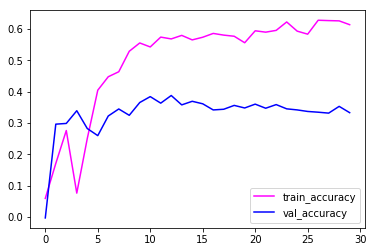

Model saved
test score: 0.55 


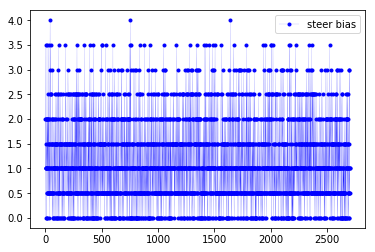

0.55278429294366638

In [102]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

#### 增加conv7,conv7_1,conv8, conv8_1

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(84, (5, 5), padding="same", activation="relu", kernel_initial

Epoch 1/1
24/24 [==============================] - 8s 338ms/step - loss: 9.8898
Epoch 1/1
61/61 [==============================] - 5s 81ms/step - loss: 3.0668
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 6.9085
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 42.7465
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 7.3982
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 16.8428
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 13.0792
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 1.6050
train score: -0.18 
val score: -0.15 
Epoch 1/1
24/24 [==============================] - 2s 79ms/step - loss: 4.8033
Epoch 1/1
61/61 [==============================] - 5s 81ms/step - loss: 1.7049
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 5.5712
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 15.9790
Epoch 1/1

43/43 [==============================] - 3s 80ms/step - loss: 0.4279
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.5014: 1
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.4510
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.1896
train score: 0.77 
val score: 0.17 
Epoch 1/1
24/24 [==============================] - 2s 79ms/step - loss: 0.2818
Epoch 1/1
61/61 [==============================] - 5s 81ms/step - loss: 0.1817
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.3289
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.7029
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.4521
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.5009
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.4320
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.1905
train score: 0.77 
val 

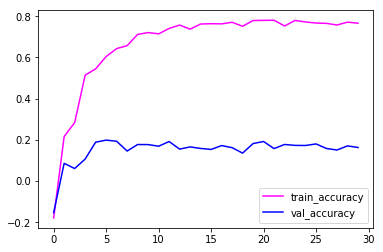

Model saved
test score: 0.55 


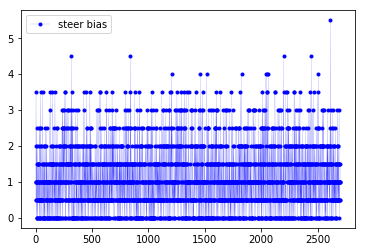

0.5538474371681763

In [91]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

#### conv5_1 1*1 con5_1 1*1都加回来

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(84, (5, 5), padding="same", activation="relu", kernel_initial

Epoch 1/1
24/24 [==============================] - 8s 332ms/step - loss: 10.4341
Epoch 1/1
61/61 [==============================] - 5s 81ms/step - loss: 3.7647
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 7.6535
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 57.5010
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 7.8598
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 12.0731
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 7.1198
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 1.7188
train score: 0.03 
val score: 0.08 
Epoch 1/1
24/24 [==============================] - 2s 80ms/step - loss: 5.4432
Epoch 1/1
61/61 [==============================] - 5s 80ms/step - loss: 1.5230
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 4.2316: 0s - l
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 12.0994
Epo

43/43 [==============================] - 3s 79ms/step - loss: 0.6850
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.3786
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.4554
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.3663
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.1674
train score: 0.52 
val score: 0.44 
Epoch 1/1
24/24 [==============================] - 2s 79ms/step - loss: 0.2443
Epoch 1/1
61/61 [==============================] - 5s 80ms/step - loss: 0.1670
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.3212
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.6455
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.3955
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.4176
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.3677
Epoch 1/1
43/43 [=========

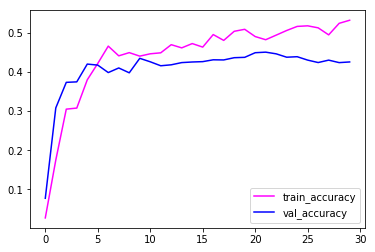

Model saved
test score: 0.50 


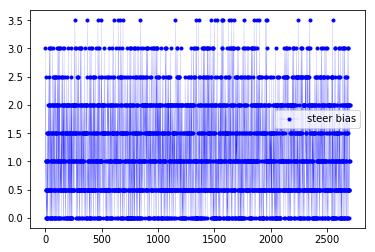

0.49784835965024199

In [89]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")